# UmojaHack Africa 2022: Faulty Air Quality Sensor Challenge
# By XFireSD Team

# Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pandas.plotting import scatter_matrix

import category_encoders as ce 
import impyute as impy
import imblearn
from sklearn.model_selection import TimeSeriesSplit

from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# Read the training and testing data


In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
ID = test_df['ID']

# Exploratory data analysis

# Features:

* $Offset fault$: Is the device faulty or not? [Target]
* $ID$: Unique Id of each sample
* $Sensor1 PM2.5$: Values of the first sensor
* $Sensor2 PM2.5$: Values of the second sensor
* $Temperature$: Temperature
* $Relative Humidity$: Relative Humidity

In [3]:
train_df.shape

(297177, 7)

In [4]:
test_df.shape

(127361, 6)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297177 entries, 0 to 297176
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ID                 297177 non-null  object 
 1   Datetime           297177 non-null  object 
 2   Sensor1_PM2.5      293563 non-null  float64
 3   Sensor2_PM2.5      293563 non-null  float64
 4   Temperature        293628 non-null  float64
 5   Relative_Humidity  293628 non-null  float64
 6   Offset_fault       297177 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 15.9+ MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127361 entries, 0 to 127360
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ID                 127361 non-null  object 
 1   Datetime           127361 non-null  object 
 2   Sensor1_PM2.5      127361 non-null  float64
 3   Sensor2_PM2.5      127361 non-null  float64
 4   Temperature        39271 non-null   float64
 5   Relative_Humidity  39271 non-null   float64
dtypes: float64(4), object(2)
memory usage: 5.8+ MB


In [7]:
train_df.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58,49.52,17.4,96.0,0
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25,33.40,25.0,75.0,0
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18,23.50,24.9,75.0,0
3,ID_6XQOMBXM2DG3,2022-01-01 18:55:15,19.40,15.48,24.9,70.0,0
4,ID_UQZW9ISJY9QE,2021-11-05 22:23:48,38.30,34.77,20.9,89.0,0


In [8]:
train_df.describe()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
count,293563.000000,293563.000000,293628.000000,293628.000000,297177.000000
mean,40.751195,38.183018,23.316554,78.653623,0.371072
std,28.526182,28.647761,3.836971,14.772725,0.483092
min,-9.450000,-9.700000,16.700000,27.000000,0.000000
25%,22.430000,19.520000,20.400000,68.000000,0.000000
50%,36.470000,33.720000,21.900000,84.000000,0.000000
75%,49.420000,47.570000,26.300000,91.000000,1.000000
max,997.960000,997.260000,34.900000,99.000000,1.000000


In [9]:
test_df.describe()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
count,127361.000000,127361.000000,39271.000000,39271.000000
mean,42.795356,43.958427,23.683838,72.215834
std,27.838730,28.260335,3.725563,18.078569
min,1.230000,0.780000,16.900000,28.000000
25%,24.670000,25.580000,20.900000,58.000000
50%,39.770000,39.880000,22.500000,78.000000
75%,52.030000,52.830000,26.500000,88.000000
max,927.780000,894.750000,34.000000,97.000000


In [10]:
#The cardinality of each catgorical feature (Training)
cat_cols = train_df.columns
for col in cat_cols:
    print(col, train_df[col].nunique())

ID 297177
Datetime 293751
Sensor1_PM2.5 9814
Sensor2_PM2.5 9971
Temperature 167
Relative_Humidity 70
Offset_fault 2


In [11]:
#The cardinality of each catgorical feature (Testing)
cat_cols = test_df.columns
for col in cat_cols:
    print(col, test_df[col].nunique())

ID 127361
Datetime 126092
Sensor1_PM2.5 8687
Sensor2_PM2.5 8893
Temperature 129
Relative_Humidity 66


### Put the date and time in separate features

In [12]:
for dataset in (train_df,test_df):
    dataset['Datetime'] = pd.to_datetime(dataset['Datetime'])
    dataset['Datetime_day'] = dataset.Datetime.dt.day
    dataset['Datetime_month'] = dataset.Datetime.dt.month
    dataset['Datetime_year'] = dataset.Datetime.dt.year
    dataset['Datetime_hour'] = dataset.Datetime.dt.hour
    dataset['Datetime_minute'] = dataset.Datetime.dt.minute
    dataset['Datetime_seconds'] = dataset.Datetime.dt.second
    dataset['Datetime_day_of_year'] = dataset.Datetime.dt.dayofyear
    dataset['Datetime_day_of_week'] = dataset.Datetime.dt.dayofweek
    dataset['Datetime_week_of_year'] = dataset.Datetime.dt.weekofyear
    dataset.drop('Datetime',axis=1,inplace=True)

# Visualizations

### Offset_fault

<AxesSubplot:>

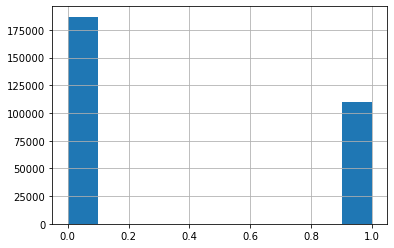

In [13]:
train_df['Offset_fault'].hist()

###### The target is imbalanced, so the data may need some over or under sampling.

### Sensor1_PM2.5

[]

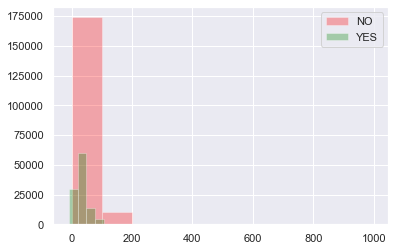

In [14]:
sns.set()
plt.hist(train_df[train_df['Offset_fault'] == 0]['Sensor1_PM2.5'], color='red', alpha = 0.3, label = 'NO')
plt.hist(train_df[train_df['Offset_fault'] == 1]['Sensor1_PM2.5'], color='green', alpha=0.3, label = 'YES')
plt.legend()
plt.plot()

### Sensor2_PM2.5

[]

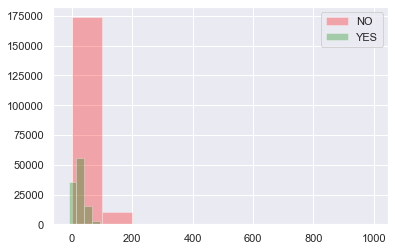

In [15]:
sns.set()
plt.hist(train_df[train_df['Offset_fault'] == 0]['Sensor2_PM2.5'], color='red', alpha = 0.3, label = 'NO')
plt.hist(train_df[train_df['Offset_fault'] == 1]['Sensor2_PM2.5'], color='green', alpha=0.3, label = 'YES')
plt.legend()
plt.plot()

### Sensor1_PM2.5 VS Sensor2_PM2.5

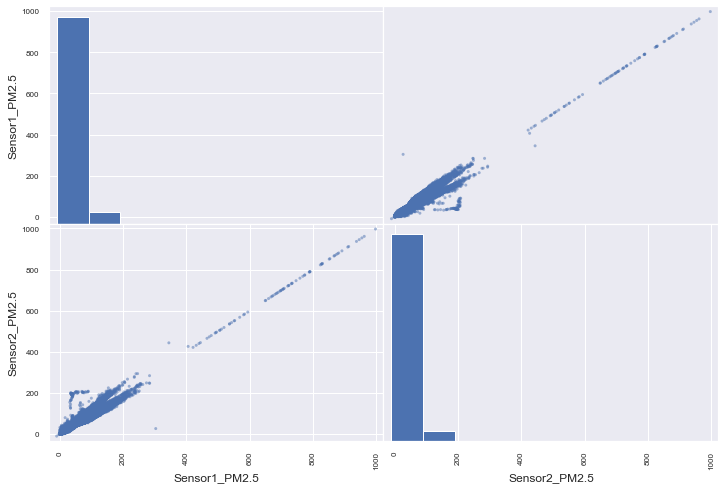

In [16]:
attributes = ["Sensor1_PM2.5", "Sensor2_PM2.5"]
scatter_matrix(train_df[attributes], figsize=(12, 8));

###### These two features are strongly correlated which suggests that they measure the same thing.

### Datetime_year

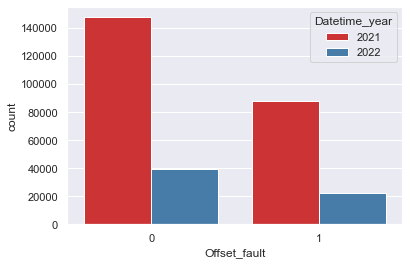

In [17]:
sns.countplot( x='Offset_fault', data=train_df, hue="Datetime_year", palette="Set1");

###### Most of the samples are from 2021. Let's check the months:

### Datetime_month

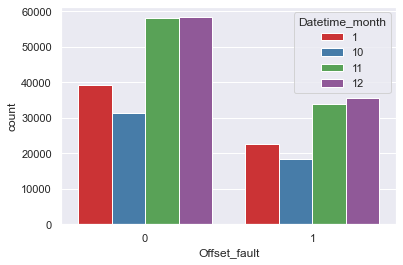

In [18]:
sns.countplot( x='Offset_fault', data=train_df, hue="Datetime_month", palette="Set1");

###### The data were taken during the last three months of 2021 and the first month of 2022 which explains the low amount of samples in 2022.

###### Let's check the test data:

<AxesSubplot:xlabel='Datetime_year', ylabel='Count'>

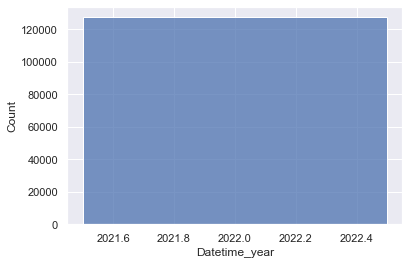

In [19]:
sns.histplot(test_df['Datetime_year'])

<AxesSubplot:xlabel='Datetime_month', ylabel='Count'>

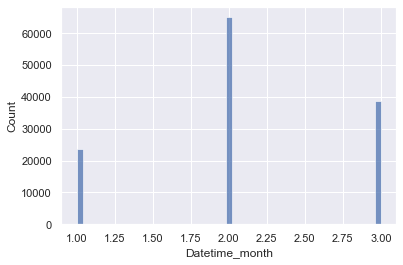

In [20]:
sns.histplot(test_df['Datetime_month'])

###### Well, it is clear that the whole dataset were taken between October 2021 and March 2022. Then it's been splited to a training and testing datasets. This would be important later to evaluate our model properly.

### Datetime_day

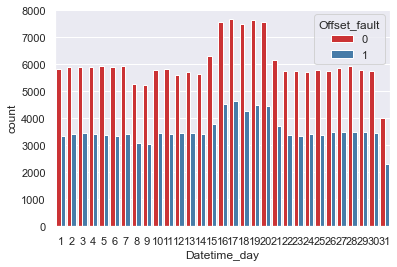

In [21]:
sns.countplot( x='Datetime_day', data=train_df, hue="Offset_fault", palette="Set1");

###### It looks like many samples were taken between 15 and 20 of each month.

### Datetime_hour

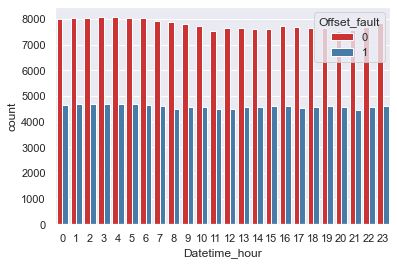

In [22]:
sns.countplot( x='Datetime_hour', data=train_df, hue="Offset_fault", palette="Set1");

###### It is distibuted uniformly so no strange trends.

### Temperature --- Datetime_month

[]

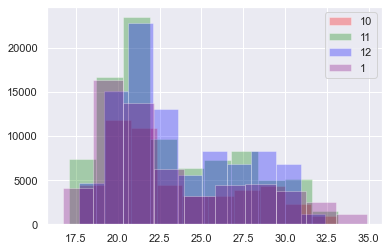

In [23]:
sns.set()
plt.hist(train_df[train_df['Datetime_month'] == 10].Temperature, color='red', alpha = 0.3, label = 10)
plt.hist(train_df[train_df['Datetime_month'] == 11].Temperature, color='green', alpha=0.3, label = 11)
plt.hist(train_df[train_df['Datetime_month'] == 12].Temperature, color='blue', alpha=0.3, label = 12)
plt.hist(train_df[train_df['Datetime_month'] == 1].Temperature, color='purple', alpha=0.3, label = 1)
plt.legend()
plt.plot()

###### The temperature for all months is almost identical with a small increase in January.

# Data preprocessing

## Missing Values

In [24]:
#missing data percentage (Training)
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data

,Total,%
Sensor1_PM2.5,3614,1.2
Sensor2_PM2.5,3614,1.2
Temperature,3549,1.2
Relative_Humidity,3549,1.2
ID,0,0.0
Offset_fault,0,0.0
Datetime_day,0,0.0
Datetime_month,0,0.0
Datetime_year,0,0.0
Datetime_hour,0,0.0


In [25]:
#missing data percentage (Testing)
total = test_df.isnull().sum().sort_values(ascending=False)
percent_1 = test_df.isnull().sum()/test_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data

,Total,%
Temperature,88090,69.2
Relative_Humidity,88090,69.2
ID,0,0.0
Sensor1_PM2.5,0,0.0
Sensor2_PM2.5,0,0.0
Datetime_day,0,0.0
Datetime_month,0,0.0
Datetime_year,0,0.0
Datetime_hour,0,0.0
Datetime_minute,0,0.0


### Using a Moving Window algorithm to impute the missing values

In [27]:
feats = ['Relative_Humidity','Temperature','Sensor1_PM2.5','Sensor2_PM2.5']
for dataset in (train_df,test_df):
    dataset[feats] = np.log(dataset[feats]+1)
    dataset[feats] = impy.moving_window(dataset[feats].to_numpy())

# Feature Engineering

### Drop the 'ID' Column

In [28]:
for dataset in (train_df,test_df):
    dataset.drop('ID',axis=1,inplace=True)

## Let's add some new features

### Make two new features that categorise the values of the sensors

In [30]:
for dataset in (train_df,test_df):
    dataset["Sensor1_bins"] = pd.cut(dataset["Sensor1_PM2.5"], bins=[-np.inf, 3.0, 3.5, 4.0, np.inf], labels=[1, 2, 3, 4])
    dataset["Sensor2_bins"] = pd.cut(dataset["Sensor2_PM2.5"], bins=[-np.inf, 3.0, 3.5, 4.0, np.inf], labels=[1, 2, 3, 4])

### The ratio between the values of the sensors

In [31]:
for dataset in (train_df,test_df):
    dataset['S1_S2'] = dataset['Sensor1_PM2.5'] - dataset['Sensor2_PM2.5']  #Note that these are the logs of values, so
                                                                            #we used subtraction

### Is weekend?

In [32]:
for dataset in (train_df,test_df):
    dataset['IsWeekend?'] = (dataset['Datetime_day_of_week'] >= 5)

### Is official hours?

In [33]:
for dataset in (train_df,test_df):
    dataset['IsOfficialHours?'] = (dataset['Datetime_hour'] >= 8) & (dataset['Datetime_hour'] <= 17)

### Time in the day

In [34]:
for dataset in (train_df,test_df):
    dataset["Time_in_day"] = pd.cut(dataset["Datetime_hour"], bins=[-np.inf, 5.0, 11.0, 17.0, 23.0], 
                                    labels=['Midnight', 'Morning', 'Afternoon', 'Evening'])

### Is Hot Day?

In [35]:
for dataset in (train_df,test_df):
    dataset['IsHot?'] = dataset['Temperature'] > dataset['Temperature'].mean()

### Heat index (a measure from Physics)

In [36]:
c1,c2,c3,c4,c5,c6,c7,c8,c9 = -42.379,-2.04901523,-10.14333127,-0.22475541, \
                            -0.00683783,-0.05481717,-0.00122874,0.00085282,-0.00000199
for dataset in (train_df,test_df):
    dataset['Heat_index'] = c1 + c2 * dataset['Temperature'] + c3 * dataset['Relative_Humidity'] + \
                            c4 * dataset['Temperature'] * dataset['Relative_Humidity'] + \
                            c5 * (dataset['Temperature']**2) + c6 * (dataset['Relative_Humidity']**2) + \
                            c7 * (dataset['Temperature']**2) * dataset['Relative_Humidity'] + \
                            c8 * (dataset['Relative_Humidity']**2) * dataset['Temperature'] + \
                            c9 * (dataset['Temperature']**2) * (dataset['Relative_Humidity']**2)

### Sort the data to help in evaluating the model properly later

In [37]:
train_df = train_df.sort_values(by = ['Datetime_year','Datetime_month','Datetime_day',
                                      'Datetime_hour'])
test_df = test_df.sort_values(by = ['Datetime_year','Datetime_month','Datetime_day',
                                      'Datetime_hour'])

# Encoding

### Target Encoder

In [38]:
from category_encoders import TargetEncoder
encoder = TargetEncoder(smoothing = 1.0)
cats = train_df.columns
cats = np.delete(cats,[0,1,2,3,4,21])
train_df[cats] = encoder.fit_transform(train_df[cats], train_df['Offset_fault'])
test_df[cats] = encoder.transform(test_df[cats])

# Checking the correlations

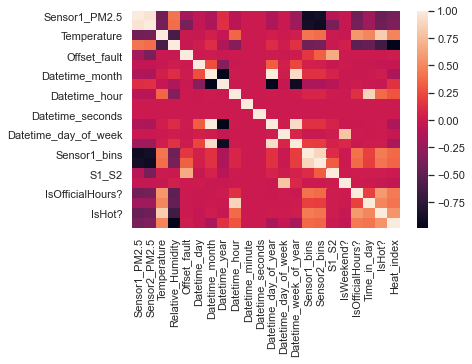

In [45]:
corr_matrix = train_df.corr()
sns.heatmap(corr_matrix);

# Oversampling using SMOTE

In [40]:
X = train_df.drop('Offset_fault',axis=1)
y = train_df['Offset_fault']

In [41]:
OvSa = imblearn.over_sampling.SMOTE(random_state=42)
X,y = OvSa.fit_resample(X,y)

# ML Modeling

## Define the model

In [42]:
params = {'n_estimators': 1040, 'max_depth': 3, 'reg_lambda': 0.16661201237472856, 
          'colsample_bytree': 0.9064439932687255, 'num_leaves': 450, 
          'min_child_samples': 21, 'subsample': 0.5564713817638391, 'random_state':0}
lgbm = LGBMClassifier(**params)

## Evaluating on the test set

#### We will use Roll-forward Window Cross-validation to evaluate our model

In [43]:
X_m = X.values
y_m = y.values

tscv = TimeSeriesSplit(n_splits=5)
scores = []

for train_index, test_index in tscv.split(X_m):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_Train, X_Test = X_m[train_index], X_m[test_index]
    y_Train, y_Test = y_m[train_index], y_m[test_index]
    lgbm.fit(X_Train,y_Train)
    y_pred = lgbm.predict(X_Test)
    scores.append(accuracy_score(y_pred,y_Test))
    
print("Scores:", scores)

TRAIN: [    0     1     2 ... 62298 62299 62300] TEST: [ 62301  62302  62303 ... 124599 124600 124601]
TRAIN: [     0      1      2 ... 124599 124600 124601] TEST: [124602 124603 124604 ... 186900 186901 186902]
TRAIN: [     0      1      2 ... 186900 186901 186902] TEST: [186903 186904 186905 ... 249201 249202 249203]
TRAIN: [     0      1      2 ... 249201 249202 249203] TEST: [249204 249205 249206 ... 311502 311503 311504]
TRAIN: [     0      1      2 ... 311502 311503 311504] TEST: [311505 311506 311507 ... 373803 373804 373805]
Scores: [0.9478981075745173, 0.8460698865186754, 0.8477552527246753, 0.8556042439126178, 0.9835315645013724]


### Final Submission

In [44]:
lgbm.fit(X, y)
test_df['Offset_fault'] = lgbm.predict(test_df)
submission = pd.DataFrame({"ID": ID ,"Offset_fault": test_df.Offset_fault})
submission.to_csv('FaultySensors.csv',index=False)